In [2]:
!pip -q uninstall -y diffusers transformers huggingface_hub
!pip -q install -U "huggingface_hub" "transformers" "diffusers"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 44.9 MB/s eta 0:00:00


In [21]:
!pip -q install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.9 MB/s eta 0:00:00


In [1]:
import torch
from diffusers import DDPMPipeline
from torchvision import datasets, transforms


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
pipe.set_progress_bar_config(disable=True)
unet = pipe.unet.eval()

def score_from_noise_pred(eps_pred, sigma):
    return -(1.0 / sigma) * eps_pred

@torch.no_grad()
def map_sigma_to_t(sigma):
    alphas_cumprod = pipe.scheduler.alphas_cumprod.to(device)
    sigmas = torch.sqrt((1 - alphas_cumprod) / alphas_cumprod)
    t = int((sigmas - sigma).abs().argmin().item())
    return t

# freeze score model params
for p in unet.parameters():
    p.requires_grad_(False)

def score_fn(x, sigma=0.1):
    t = map_sigma_to_t(sigma)
    t_tensor = torch.full((x.shape[0],), t, device=x.device, dtype=torch.long)
    eps_pred = unet(x, t_tensor).sample
    return score_from_noise_pred(eps_pred, sigma)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [3]:
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda z: z*2-1),
])
cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
loader = torch.utils.data.DataLoader(cifar, batch_size=64, shuffle=True, num_workers=2)


In [4]:
def k_gauss(X, Y, sigma2=0.5):
    # X: (n,d), Y: (m,d)
    XX = (X**2).sum(dim=1, keepdim=True)
    YY = (Y**2).sum(dim=1, keepdim=True)
    dist2 = XX - 2*X@Y.T + YY.T
    return torch.exp(-dist2 / (2 * sigma2))


In [5]:
import numpy as np

def select_renyi_landmarks_np(X, m, sigma2=0.5):
    Xn = X.detach().cpu().numpy()
    n = Xn.shape[0]
    Xn = Xn.reshape(n, -1)  # flatten images

    m = min(m, n)
    XX = (Xn**2).sum(axis=1, keepdims=True)
    dist2 = XX - 2 * Xn @ Xn.T + XX.T
    K = np.exp(-dist2 / (2 * sigma2))
    diag = np.diag(K)

    row_sums = K.sum(axis=1)
    first = int(np.argmin(row_sums))
    selected = [first]
    cross_sums = K[:, first].copy()

    while len(selected) < m:
        scores = 2 * cross_sums + diag
        scores[selected] = np.inf
        nxt = int(np.argmin(scores))
        selected.append(nxt)
        cross_sums += K[:, nxt]

    return np.array(selected, dtype=int)


In [6]:
class RenyiNystroemKSDTorch:
    def __init__(self, score_fn, sigma2=0.5, m_fn=lambda n: int(4*torch.sqrt(torch.tensor(n)).item())):
        self.score_fn = score_fn
        self.sigma2 = sigma2
        self.m_fn = m_fn

    def h_p(self, X, Y):
        # keep image shape for score, flatten for kernel
        X_flat = X.view(X.shape[0], -1)
        Y_flat = Y.view(Y.shape[0], -1)

        grad_logpX = self.score_fn(X).view(X.shape[0], -1)
        grad_logpY = self.score_fn(Y).view(Y.shape[0], -1)

        diff = X_flat[:, None, :] - Y_flat[None, :, :]
        dist2 = (diff**2).sum(dim=2)
        K = torch.exp(-dist2 / (2 * self.sigma2))

        gram_glogp = grad_logpX @ grad_logpY.T
        gradX = -(diff / self.sigma2) * K[:, :, None]
        gradY = -gradX

        B = (gradX * grad_logpY[None, :, :]).sum(dim=2)
        C = (gradY * grad_logpX[:, None, :]).sum(dim=2)

        d = X_flat.shape[1]
        gradXY_sum = (dist2 / (self.sigma2**2) - d / self.sigma2) * K

        return K * gram_glogp + B + C + gradXY_sum

    def compute_stat(self, X):
        n = X.shape[0]
        m = min(self.m_fn(n), n)
        idx = select_renyi_landmarks_np(X, m, sigma2=self.sigma2)
        idx = torch.as_tensor(idx, device=X.device)

        H_mn = self.h_p(X[idx], X)
        H_mm = H_mn[:, idx]
        H_mm_inv = torch.linalg.pinv(H_mm)
        beta = H_mn @ (torch.ones(n, 1, device=X.device) / n)
        stat = (beta.T @ H_mm_inv @ beta).squeeze()
        return stat


In [7]:
ksd = RenyiNystroemKSDTorch(score_fn=score_fn, sigma2=1.0)

x, _ = next(iter(loader))
x = x.to(device)
loss = ksd.compute_stat(x)
print("KSD stat:", loss.item())


KSD stat: 248.15969848632812


In [8]:
import torch.nn as nn

import torch.nn as nn

class DCGANGen(nn.Module):
    def __init__(self, z_dim=128, ngf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)

G = DCGANGen(z_dim=128).to(device)
opt = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))





In [9]:
batch_size = 64
z = torch.randn(batch_size, 128, 1, 1, device=device)
fake = G(z)
loss = ksd.compute_stat(fake)
opt.zero_grad()
loss.backward()
opt.step()

print("Generator step done, loss:", loss.item())


Generator step done, loss: 4221.39404296875


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KSD(real) baseline: mean=231.58, std=11.76


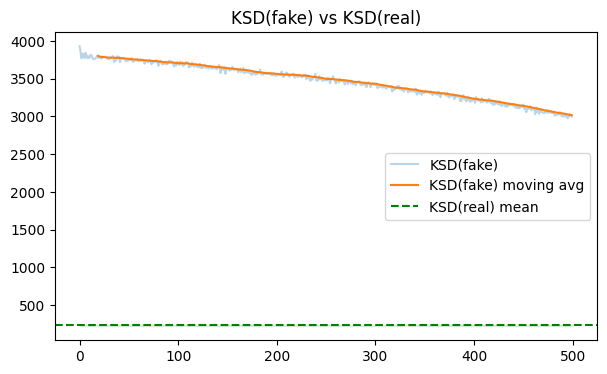

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# baseline from a few real batches
real_vals = []
for _ in range(5):
    xr, _ = next(iter(loader))
    xr = xr.to(device)
    real_vals.append(ksd.compute_stat(xr).item())
real_mean = np.mean(real_vals)
real_std = np.std(real_vals)

print(f"KSD(real) baseline: mean={real_mean:.2f}, std={real_std:.2f}")

# training loop
steps = 500
losses = []
batch_size = 64  # keep consistent with your loader
for i in range(steps):
    z = torch.randn(batch_size, 128, 1, 1, device=device)
    fake = G(z)  # already (B,3,32,32)
    loss = ksd.compute_stat(fake)

    if not torch.isfinite(loss):
        print("Skipping step due to non-finite loss")
        continue

    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)
    opt.step()

    losses.append(loss.item())

# moving average
window = 20
mov = np.convolve(losses, np.ones(window)/window, mode="valid")

plt.figure(figsize=(7,4))
plt.plot(losses, alpha=0.3, label="KSD(fake)")
plt.plot(range(window-1, window-1+len(mov)), mov, label="KSD(fake) moving avg")
plt.axhline(real_mean, color="green", linestyle="--", label="KSD(real) mean")
plt.fill_between([0, steps], real_mean-real_std, real_mean+real_std, color="green", alpha=0.1)
plt.legend()
plt.title("KSD(fake) vs KSD(real)")
plt.show()


#COMPARISON

In [18]:
import copy
G_ksd = copy.deepcopy(G).eval()

In [19]:
import torch.nn as nn

class DCGANDiscriminator(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.net(x).view(-1)

# new generator for GAN baseline (same architecture as KSD run)
G_gan = DCGANGen(z_dim=128).to(device)
D = DCGANDiscriminator().to(device)

criterion = nn.BCEWithLogitsLoss()
optG = torch.optim.Adam(G_gan.parameters(), lr=1e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

steps = 500
batch_size = 64
data_iter = iter(loader)
gan_losses = []

for i in range(steps):
    try:
        real, _ = next(data_iter)
    except StopIteration:
        data_iter = iter(loader)
        real, _ = next(data_iter)
    real = real.to(device)

    # --- Train D ---
    z = torch.randn(batch_size, 128, 1, 1, device=device)
    fake = G_gan(z).detach()

    real_logits = D(real)
    fake_logits = D(fake)

    lossD = criterion(real_logits, torch.ones_like(real_logits)) + \
            criterion(fake_logits, torch.zeros_like(fake_logits))

    optD.zero_grad(set_to_none=True)
    lossD.backward()
    optD.step()

    # --- Train G ---
    z = torch.randn(batch_size, 128, 1, 1, device=device)
    fake = G_gan(z)
    lossG = criterion(D(fake), torch.ones_like(real_logits))

    optG.zero_grad(set_to_none=True)
    lossG.backward()
    optG.step()

    gan_losses.append(lossG.item())


In [20]:
import numpy as np

def ksd_on_generator(G, n_batches=5):
    vals = []
    for _ in range(n_batches):
        z = torch.randn(batch_size, 128, 1, 1, device=device)
        fake = G(z)
        vals.append(ksd.compute_stat(fake).item())
    return float(np.mean(vals)), float(np.std(vals))

# baseline KSD(real)
real_vals = []
for _ in range(5):
    xr, _ = next(iter(loader))
    xr = xr.to(device)
    real_vals.append(ksd.compute_stat(xr).item())
real_mean = float(np.mean(real_vals))
real_std = float(np.std(real_vals))

ksd_ksd_mean, ksd_ksd_std = ksd_on_generator(G_ksd)
ksd_gan_mean, ksd_gan_std = ksd_on_generator(G_gan)

print(f"KSD(real): {real_mean:.2f} ± {real_std:.2f}")
print(f"KSD(fake) Renyi-KSD: {ksd_ksd_mean:.2f} ± {ksd_ksd_std:.2f}")
print(f"KSD(fake) GAN:       {ksd_gan_mean:.2f} ± {ksd_gan_std:.2f}")


KSD(real): 209.77 ± 12.58
KSD(fake) Renyi-KSD: 50.21 ± 0.48
KSD(fake) GAN:       1713.84 ± 8.57


In [22]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.kid import KernelInceptionDistance

fid = FrechetInceptionDistance(feature=2048).to(device)
kid = KernelInceptionDistance(subset_size=50).to(device)

def to_uint8(x):
    # x in [-1,1] -> uint8 [0,255]
    x = (x + 1) / 2
    x = x.clamp(0, 1)
    return (x * 255).to(torch.uint8)

@torch.no_grad()
def eval_fid_kid(G, n_batches=10, batch_size=64):
    fid.reset(); kid.reset()
    data_iter = iter(loader)
    for _ in range(n_batches):
        try:
            real, _ = next(data_iter)
        except StopIteration:
            data_iter = iter(loader)
            real, _ = next(data_iter)
        real = real.to(device)

        z = torch.randn(batch_size, 128, 1, 1, device=device)
        fake = G(z)

        fid.update(to_uint8(real), real=True)
        fid.update(to_uint8(fake), real=False)

        kid.update(to_uint8(real), real=True)
        kid.update(to_uint8(fake), real=False)

    return fid.compute().item(), kid.compute().item()

fid_ksd, kid_ksd = eval_fid_kid(G_ksd)
fid_gan, kid_gan = eval_fid_kid(G_gan)

print(f"Renyi-KSD: FID={fid_ksd:.2f}, KID={kid_ksd:.4f}")
print(f"GAN:       FID={fid_gan:.2f}, KID={kid_gan:.4f}")


ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [ ]:
@torch.no_grad()
def ksd_on_batch(x):
    return ksd.compute_stat(x).item()

x_real, _ = next(iter(loader))
x_real = x_real.to(device)

x_noise = torch.randn_like(x_real).clamp(-1, 1)
x_const = torch.zeros_like(x_real)

# noisy real at same sigma
sigma = 0.1
t = map_sigma_to_t(sigma)
t_tensor = torch.full((x_real.shape[0],), t, device=device, dtype=torch.long)
noise = torch.randn_like(x_real)
x_real_noisy = pipe.scheduler.add_noise(x_real, noise, t_tensor)

print("KSD(real):        ", ksd_on_batch(x_real))
print("KSD(real+noise):  ", ksd_on_batch(x_real_noisy))
print("KSD(noise):       ", ksd_on_batch(x_noise))
print("KSD(constant):    ", ksd_on_batch(x_const))
